In [298]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from soft_knn import SoftKNN
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import fractions
import itertools
from collections import Counter


In [2]:
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
def create_system(n, verbose=False):
    A=[]
    for i in range(1,int(np.ceil(n/2.))):
        for j in range(2*i, n):#int(np.floor(n/2.))+i
            vector = np.zeros(n)
            vector[i-1]+=(1./(j/2.))
            vector[n-i+1-1]+=(1/(n-(j/2.)))
            vector[j-i+1-1]+=(-1./(j/2.))
            vector[n-j+i-1]+=(-1/(n-(j/2.)))
            A.append(vector)
            if verbose:
                print ("(y_{0}/{1})+(y_{2}/{3}) = (y_{4}/{1}) + (y_{5}/{3})    ".format(i,j/2.,n-i+1,n-(j/2.),j-i+1,n-j+i))
        if verbose: 
            print("\n")
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b
def solve_system(A,b):
    soln, _, _, _ = np.linalg.lstsq(A,b,rcond=None)
    return soln
def labels_2_points_n_classes(n):
    denom = sum([j**2 for j in range(1,n)])
    y=[(n*(n-1)-i*(i-1))/denom for i in range(1,n+1)]
    return y
    

<IPython.core.display.Javascript object>


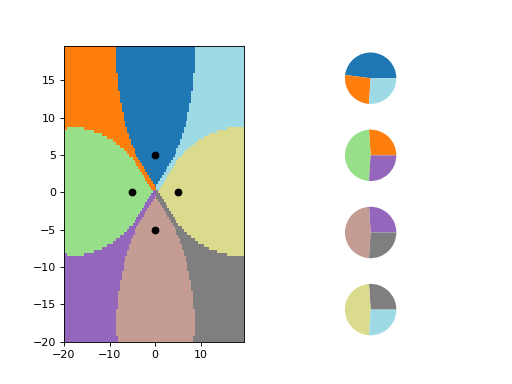

Button(description='Save image', style=ButtonStyle())

Output()

interactive(children=(IntSlider(value=10, continuous_update=False, description='frame', max=60, min=-60, step=…

In [3]:
ims=[]
fig=plt.figure()


def animate(frame, num_points, num_classes, mode, resolution, zoom, filename):
    
    #frame+=20
    ax_list=fig.axes
    [fig.delaxes(ax) for ax in ax_list]
    ax1 = fig.add_subplot(1,2,1)
    axs = [fig.add_subplot(num_points,2,2*(point+1)) for point in range(num_points)]
    if mode == "poly_and_center":
        frame+=20
        num_classes = 2*(num_points-1)+num_points
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points-1, radius=5)
        dd=polygon.get_verts()[:-1]
        dd=np.append(dd,np.array([[0,0]]),axis=0)
        dy=np.zeros((num_points,num_classes))
        for i in range(num_points-1): 
            #Set the surrounding polygon classes
            dy[i][2*i]=0.4-frame*0.0012
            dy[i][(2*i+1)%(2*(num_points-1))]=0.2+frame*0.0004
            dy[i][(2*i-1)%(2*(num_points-1))]=0.2+frame*0.0004
            dy[i][(2*(num_points-1)+i)]=0.2+frame*0.0004
            #Set the central classes
            dy[-1][(2*(num_points-1)+i)]=0.2+frame*0.0004
        dy[-1][-1]=0.4-frame*0.0004*(num_points-1)
    if mode =="every_other":
        num_classes = 2*num_points
        polygon = matplotlib.patches.RegularPolygon((0,0),num_classes, radius=5)
        dd=polygon.get_verts()[:-1:2]
        dy=np.zeros((num_points,num_classes))
        for i in range(num_points):
            dy[i][2*i]=0.49-frame*0.001
            dy[i][(2*i+1)%num_classes]=0.255+frame*0.0005
            dy[i][(2*i-1)%num_classes]=0.255+frame*0.0005
    if mode == "poly_every_subset":
        num_classes = 2**num_points - 1
        polygon = matplotlib.patches.RegularPolygon((0,0),num_points, radius=5)
        dd=polygon.get_verts()[:-1]
        dy=np.full((num_points,num_classes),num_points/num_classes)
        #Incomplete
    if mode == "2points_n_classes":
        dd=np.array([[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[0] = labels_2_points_n_classes(num_classes)
        #A, b = create_system(num_classes)
        #dy[0]=solve_system(A,b)
        
#         if num_classes ==3:
#             dy[0]=np.array([3/5,2/5,0])
#         if num_classes==4:
#             #dy[0]=np.array([5/12,4/12,3/12,0])
#             dy[0]=np.array([6/14,5/14,3/14,0])
#         if num_classes==5:
#             dy[0]=np.array([60/200,49/200,47/200,44/200,0])
#         if num_classes==6:
#             dy[0]=np.array([56/210,52/210,42/210,40/210,20/210,0])

     
        dy[1]=dy[0][::-1]    
    if mode == "3points_n_classes":
        dd=np.array([[-1,0],[0,0],[1,0]])
        dy=np.zeros((num_points,num_classes))
        
        dy[0] = labels_2_points_n_classes(num_classes)
        #A, b = create_system(num_classes)
        #dy[0]=solve_system(A,b)
        
#         if num_classes ==3:
#             dy[0]=np.array([3/5,2/5,0])
#         if num_classes==4:
#             #dy[0]=np.array([5/12,4/12,3/12,0])
#             dy[0]=np.array([6/14,5/14,3/14,0])
#         if num_classes==5:
#             dy[0]=np.array([60/200,49/200,47/200,44/200,0])
#         if num_classes==6:
#             dy[0]=np.array([56/210,52/210,42/210,40/210,20/210,0])

     
        dy[1]=dy[0][::-1] 
        dy[2]=dy[0]  
    #print(dy)
    if not mode != "true":
        distX=[]
        distY=[]
        for i in range(num_points):
            class_list = []
            for j in range(num_classes):
                class_list.append(int(dy[i][j]*granularity)+1*(mode!="2points_n_classes"))
                distY.append(np.repeat(j, class_list[-1]))
            #print(class_list)
            #class_list.append(granularity-sum(class_list))
            #print(class_list)
            #distY.append(np.repeat(i, class_list[-1]))
            distX.append(np.repeat([dd[i]], sum(class_list),axis=0))
            #tempy=
            
            
        distX=np.concatenate(distX)
        distY=np.concatenate(distY)
    distX=dd
    distY=dy
        #print(distX)
        #print(distY)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFA8E8', '#A8FFE8', '#E8A8FF', '#E8FFA8' ])
    cmap_bold = ListedColormap(['#FF8888', '#88FF88', '#8888FF', '#994282', '#429982', '#824299' ,'#829942' ])
    cmap_bolder = ListedColormap(['#000000', '#000000', '#000000'])
    colors=['#FFAAAA', '#AAFFAA', '#AAAAFF']
    if num_classes>20:
        cmap="gist_ncar"
    else:
        cmap="tab20"
    cmap_single = get_cmap(num_classes, cmap)
    colors=cmap_single(range(num_classes))
    # create KNN classifier
    clf = SoftKNN()
    #clf = neighbors.KNeighborsClassifier(min(n_neighbors, len(distX)), weights=weights)
    clf.fit(distX, distY)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if mode=="2points_n_classes":
        x_min, x_max = -0-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="3points_n_classes":
        x_min, x_max = -1-5+zoom, 1 + 5-zoom
        y_min, y_max = -1+(-5+zoom)/2, 1 + (5-zoom)/2
    elif mode=="every_other":
        x_min, x_max = -20,20
        y_min, y_max = -20,20
    else:
        x_min, x_max = -10,10
        y_min, y_max = -10,10
    size = (x_max-x_min)*(y_max-y_min)
    desired_particles = 6000./resolution
    h = (size/desired_particles)**0.5  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax1.clear()
    ax1.pcolormesh(xx, yy, Z, cmap=cmap_single)
    if not mode =="true": 
        ax1.scatter(distX[:, 0], distX[:, 1], c="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #plt.title("3-Class classification (k = %i)")
    for i in range(num_points):
        axs[i].pie(dy[i], colors=colors)

    if mode== "2points_n_classes":
        axs[0].title.set_text("Left")
        axs[1].title.set_text("Right")


#play = widgets.Play(
#      value=50,
#      min=0,
#      max=100,
#      step=1,
#      interval=2000,
#      description="Press play",
#     disabled=False
#  )
# slider=widgets.IntSlider()
# widgets.jslink((play, 'value'), (slider, 'value'))
# widgets.HBox([play, slider])
#interact(animate,frame=10)
frame=widgets.IntSlider(min=-60, max=60, value=10, step=10, continuous_update=False)
num_points=widgets.IntSlider(min=2, max=12, continuous_update=False)
num_classes=widgets.IntSlider(min=2, max=24, disabled=True, continuous_update=False)
mode=widgets.Dropdown(
    options=['poly_and_center', 'every_other', '2points_n_classes', '3points_n_classes'],
    value='every_other',
    description='Mode:',
    disabled=False,
)
resolution = widgets.RadioButtons(
    options=[("Very Low",1.0),("Low",0.8),("Medium",0.6),("High", 0.4),("Very High", 0.2)],
    description='Resolution:',
    value=0.6,
    disabled=False
)
zoom = widgets.IntSlider(min=-5, max=5, value=5, step=1, continuous_update=False, disabled=True)
filename=widgets.Text(
    value='image.png',
    placeholder='image.png',
    description='Filename:',
    disabled=False
)
# save=widgets.Button(
#     description='Save Image')
# output = widgets.Output()

# display(save, output)
# def on_save(b):
#     with output:
#         plt.savefig("abc")
# save.on_click(on_save)
from IPython.display import display
button = widgets.Button(description='Save image')
output = widgets.Output()
display(button, output)
def on_save(b):
    with output:
        plt.savefig(filename.value)


button.on_click(on_save)


def update_points_range(*args):
    if mode.value=="every_other":
        num_classes.max=2*num_points.max
        num_classes.min=1
        num_classes.value = num_points.value*2
        num_classes.disabled=True
        num_points.disabled=False
        num_points.max = 12
        num_points.min = 4
        frame.disabled=False
        zoom.disabled=True
    if mode.value=="poly_and_center":
        num_points.disabled=False
        num_points.max = 12
        num_points.min = 4
        num_classes.max=3*num_points.max-2
        num_classes.min=1
        num_classes.value = 3*num_points.value-2
        num_classes.disabled=True
        frame.disabled=False
        zoom.disabled=True

    if mode.value=="2points_n_classes":
        num_points.min = 2
        num_points.max = 2
        num_points.value = 2
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2
    if mode.value=="3points_n_classes":
        num_points.min = 3
        num_points.max = 3
        num_points.value = 3
        num_points.disabled=True
        num_classes.min=2
        num_classes.max=20
        num_classes.value=3
        num_classes.disabled=False
        frame.disabled=True
        zoom.disabled=False
        resolution.value=0.2

mode.observe(update_points_range, 'value')
num_points.observe(update_points_range)
interactive_plot=interactive(animate,frame=frame, num_points=num_points, num_classes=num_classes,mode=mode, resolution=resolution, zoom=zoom, filename=filename)
output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot



In [131]:

def expected_num_eqns(n):
    return (np.ceil(n/2.)-1)*(n-np.ceil(n/2.))
n=7
A,b=create_system(n, verbose=False)
print ("Expected: {0} Found: {1}".format(expected_num_eqns(n),len(A)-2))
#print("".join([str(a)+"\n" for a in A]))

C=A[:(n-2)]
C.append(A[-1])
C.append(A[-2])
# if n%2==1:
#C.append(A[-3])
print(np.linalg.matrix_rank(C))
def solve_system(A,b):
    soln, rsq, _, _ = np.linalg.lstsq(A,b,rcond=None)
    return soln, rsq
#print(solve_system(A,b))



Expected: 9.0 Found: 9
7


In [150]:
def create_system(n, verbose=False):
    A=[]
    for i in range(1,int(np.ceil(n/2.))):
        for j in range(2*i, n):#int(np.floor(n/2.))+i
            vector = np.zeros(n)
            vector[i-1]+=(2*n-j)
            vector[n-i+1-1]+=(j)
            vector[j-i+1-1]+=(-(2*n-j))
            vector[n-j+i-1]+=(-j)
            A.append(vector)
            if verbose:
                print ("(y_{0}/{1})+(y_{2}/{3}) = (y_{4}/{1}) + (y_{5}/{3})    ".format(i,j/2.,n-i+1,n-(j/2.),j-i+1,n-j+i))
        if verbose: 
            print("\n")
    A.append(np.ones(n))
    A.append(np.zeros(n))
    A[-1][-1]=1
    b = np.zeros(len(A))
    b[-2]=1
    return A, b
def expected_num_eqns(n):
    return (np.ceil(n/2.)-1)*(n-np.ceil(n/2.))
n=8
A,b=create_system(n, verbose=False)
print ("Expected: {0} Found: {1}".format(expected_num_eqns(n),len(A)-2))
print("".join([str(a)+"\n" for a in A]))

C=A[:(n-2)]
C.append(A[-1])
C.append(A[-2])
# if n%2==1:
#C.append(A[-3])
print(np.linalg.matrix_rank(C))
def solve_system(A,b):
    soln, rsq, _, _ = np.linalg.lstsq(A,b,rcond=None)
    return soln, rsq
#print(solve_system(A,b))
soln=solve_system(A,b)[0]
print([str(fractions.Fraction(i).limit_denominator()) for i in soln])
choices = np.transpose(np.array(A[:n-2]))
#print(choices)
target=A[n-2+n-4]
#print(target)
soln=solve_system(choices, target)
[str(fractions.Fraction(i).limit_denominator()) for i in soln[0]]

Expected: 12.0 Found: 12
[ 14. -14.   0.   0.   0.   0.  -2.   2.]
[ 13.   0. -13.   0.   0.  -3.   0.   3.]
[ 12.   0.   0. -12.  -4.   0.   0.   4.]
[ 11.   0.   0.  -5. -11.   0.   0.   5.]
[ 10.   0.  -6.   0.   0. -10.   0.   6.]
[ 9. -7.  0.  0.  0.  0. -9.  7.]
[  0.  12. -12.   0.   0.  -4.   4.   0.]
[  0.  11.   0. -11.  -5.   0.   5.   0.]
[  0.  10.   0.  -6. -10.   0.   6.   0.]
[ 0.  9. -7.  0.  0. -9.  7.  0.]
[  0.   0.  10. -10.  -6.   6.   0.   0.]
[ 0.  0.  9. -7. -9.  7.  0.  0.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 1.]

8
['1/5', '27/140', '5/28', '11/70', '9/70', '13/140', '1/20', '0']


['0', '-4/7', '5/7', '2/7', '-3/7', '0']

Expected: 63 Found: 49


<IPython.core.display.Javascript object>


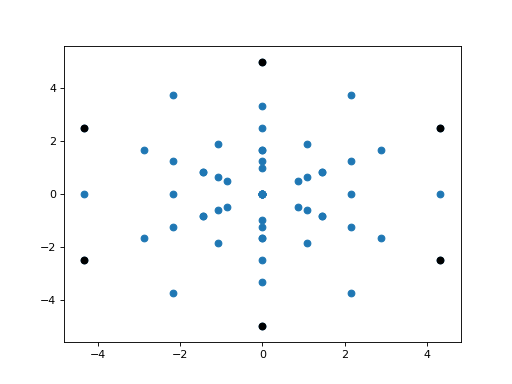

[Fraction(-3650401, 843024), Fraction(-5, 2)]
[Fraction(-3650401, 843024), Fraction(0, 1)]
[Fraction(-3650401, 843024), Fraction(5, 2)]
[Fraction(-2823595, 978122), Fraction(-5, 3)]
[Fraction(-2823595, 978122), Fraction(5, 3)]
[Fraction(-602548, 278305), Fraction(-15, 4)]
[Fraction(-602548, 278305), Fraction(-5, 4)]
[Fraction(-602548, 278305), Fraction(0, 1)]
[Fraction(-602548, 278305), Fraction(5, 4)]
[Fraction(-602548, 278305), Fraction(15, 4)]
[Fraction(-1205096, 834915), Fraction(-5, 6)]
[Fraction(-1205096, 834915), Fraction(5, 6)]
[Fraction(-301274, 278305), Fraction(-15, 8)]
[Fraction(-301274, 278305), Fraction(-5, 8)]
[Fraction(-301274, 278305), Fraction(5, 8)]
[Fraction(-301274, 278305), Fraction(15, 8)]
[Fraction(-489061, 564719), Fraction(-1, 2)]
[Fraction(-489061, 564719), Fraction(1, 2)]
[Fraction(0, 1), Fraction(-5, 1)]
[Fraction(0, 1), Fraction(-10, 3)]
[Fraction(0, 1), Fraction(-5, 2)]
[Fraction(0, 1), Fraction(-5, 3)]
[Fraction(0, 1), Fraction(-5, 4)]
[Fraction(0, 1), F

In [319]:
def find_centroids(points):
        subsets=[]
        centroids=[]
        for i in range(len(points)):
            for subset in itertools.combinations(points,i+1):
                subsets.append(subset)
                centroid = np.round(np.mean(subset,0),14)
                centroids.append(centroid)
        return centroids
def unique_points(points):
        unique_data = np.unique(points, return_counts=True, axis=0)#[list(x) for x in set(tuple(x) for x in points)]
        return unique_data
for n in range(6,7):
    polygon = matplotlib.patches.RegularPolygon((0,0),n, radius=5)
    dd=polygon.get_verts()[:-1]


    centroids2=np.array(find_centroids(dd))
    #print(centroids2)
    unique_data,counts=unique_points(centroids2)
    print("Expected: {0} Found: {1}".format(len(centroids2),len(unique_data)))
    plt.scatter(centroids2[:,0],centroids2[:,1])
    plt.scatter(dd[:,0],dd[:,1], color="black")
    fracs=[[fractions.Fraction(i).limit_denominator() for i in coord] for coord in unique_data]
    [print(frac) for frac in fracs]
    print(counts)
    #print(centroids[0:100])

In [507]:
import sympy
from tqdm.notebook import tqdm
from sympy.geometry.util import centroid
from sympy.plotting import plot as symplot


from sympy.utilities.iterables import subsets

from sympy.utilities.iterables import uniq

def find_centroids(points):
        subs=list(subsets(points))
        centroids=[centroid(*subset) for subset in  tqdm(subs)]
#             for subset in ksubsets(points,i+1): #(itertools.combinations(points,i+1)):
#                 #subsets.append(subset)
#                 centr= centroid(*subset)
#                 centroids.append(centr)
        return subs[1:], centroids[1:]

def unique_points(points):
        unique_data = uniq(points)
        return unique_data
def find_generating_vertices(target,centroids,subs, testing=False):
    reps = centroids.count(target)
    indices=[-1]
    for i in range(reps):
        last_index=indices[-1]
        index=centroids[last_index+1:].index(target)+last_index+1
#         print(centroids[index])
        indices.append(index)
    indices=indices[1:]
    out_subs = [subs[i] for i in indices]
#     print(out_subs)
    if testing:
        test_centroids = [centroid(*sub) for sub in out_subs]
#     print(test_centroids)
#     print(target)
        test=[centr.equals(target) for centr in test_centroids]
#     print(test)
    
        assert(all(test))
    return out_subs
def find_unique_combos(points):
        #print(points.shape)
        unique_data = np.unique(points, return_counts=True, axis=0)#[list(x) for x in set(tuple(x) for x in points)]
        return unique_data
def overlap_summary(overlaps):
    ocounts = [overlap[0] for overlap in overlaps]
    targets = [overlap[1] for overlap in overlaps]
    combos=[]
    #print(ocounts)
    for overlap in overlaps:
        ocount,otarget=overlap
        #print("Target: {0} Freq: {1}".format(otarget,ocount))
        ogens=find_generating_vertices(otarget,centroids,subs)
        size_set=[len(gen_set) for gen_set in ogens]
        #print(size_set)
        #[print("Size: {0}".format(len(gen_set))) for gen_set in ogens]
        combo=[ocount, str(size_set)]
        combos.append(combo)
    combos=np.array(combos)
    unique_combos, combo_counts = find_unique_combos(combos)
    [print(it) for it in list(zip(unique_combos,combo_counts))]
    #print(combo_counts)
for n in range(10,11):
    p=sympy.Polygon((0,0),5,n=n)
    dd=p.vertices
    

    subs, centroids=find_centroids(dd)
    unique_data=list(unique_points(centroids))
    counts = [centroids.count(u) for u in unique_data]
    print("Expected: {0} Found: {1}".format(len(centroids),len(unique_data)))
#     plt.scatter([centroid[0]for centroid in centroids],[centroid[1] for centroid in centroids])
    #plt.scatter([unique[0] for unique in unique_data],[unique[1] for unique in unique_data])
    print(counts)
    zipped=list(zip(counts,unique_data))
    #[plt.scatter(i[0],i[1], color="black") for i in dd]
    overlaps=[tup for tup in zipped if tup[0]>1]
    #[plt.scatter(tup[1][0],tup[1][1]) for tup in overlaps]
    #[print(i) for i in overlaps]
#     print("Centroid 0")
#     print(centroids[0])
#     print(subs[0])
#     print(centroid(*subs[0]))
#     print("Done")
    #print(centroids.index(overlaps[1][1]))
    overlap_summary(overlaps)
#     for overlap in overlaps:
#         count,target=overlap
#         print("Target: {0} Freq: {1}".format(target,count))
#         gens=find_generating_vertices(target,centroids,subs)
#         [print("Size: {0}\n{1}".format(len(gen_set),gen_set)) for gen_set in gens]
#         print("\n")
    #print(counts)
    #print(centroids[0:100])

SympifyError: Sympify of expression 'could not parse '<generator object subsets at 0x7fd31bafff48>'' failed, because of exception being raised:
SyntaxError: invalid syntax (<string>, line 1)

In [415]:
def find_unique_combos(points):
        #print(points.shape)
        unique_data = np.unique(points, return_counts=True, axis=0)#[list(x) for x in set(tuple(x) for x in points)]
        return unique_data
def overlap_summary(overlaps):
    ocounts = [overlap[0] for overlap in overlaps]
    targets = [overlap[1] for overlap in overlaps]
    combos=[]
    #print(ocounts)
    for overlap in overlaps:
        ocount,otarget=overlap
        #print("Target: {0} Freq: {1}".format(otarget,ocount))
        ogens=find_generating_vertices(otarget,centroids,subs)
        size_set=[len(gen_set) for gen_set in ogens]
        #print(size_set)
        #[print("Size: {0}".format(len(gen_set))) for gen_set in ogens]
        combo=[ocount, str(size_set)]
        combos.append(combo)
    combos=np.array(combos)
    unique_combos, combo_counts = find_unique_combos(combos)
    [print(it) for it in list(zip(unique_combos,combo_counts))]
    #print(combo_counts)
overlap_summary(overlaps)
#print(counts.count(10))
#print(counts.count(6))

(array(['10', '[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]'], dtype='<U304'), 12)
(array(['12', '[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]'], dtype='<U304'), 12)
(array(['12', '[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]'], dtype='<U304'), 12)
(array(['2', '[5, 5]'], dtype='<U304'), 12)
(array(['2', '[6, 6]'], dtype='<U304'), 180)
(array(['2', '[7, 7]'], dtype='<U304'), 12)
(array(['2', '[9, 9]'], dtype='<U304'), 36)
(array(['3', '[3, 3, 6]'], dtype='<U304'), 36)
(array(['3', '[5, 5, 5]'], dtype='<U304'), 84)
(array(['3', '[7, 7, 7]'], dtype='<U304'), 84)
(array(['4', '[4, 4, 4, 4]'], dtype='<U304'), 12)
(array(['4', '[8, 8, 8, 8]'], dtype='<U304'), 12)
(array(['5', '[4, 4, 4, 4, 4]'], dtype='<U304'), 36)
(array(['5', '[8, 8, 8, 8, 8]'], dtype='<U304'), 36)
(array(['5', '[9, 9, 9, 9, 9]'], dtype='<U304'), 12)
(array(['6', '[4, 4, 4, 4, 4, 4]'], dtype='<U304'), 12)
(array(['6', '[5, 5, 5, 5, 5, 5]'], dtype='<U304'), 36)
(array(['6', '[6, 6, 6, 6, 6, 6]'], dtype='<U304'), 12)
(array(['6', '[7, 7, 7, 7, 7, 7]'], 

[   0    2    0   14    0   70    0  382    0 2390    0 7627 3908]


<IPython.core.display.Javascript object>


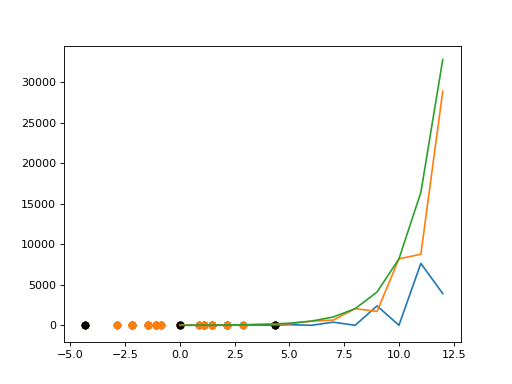

In [299]:
found=[7,13,31,49,127,185,511,641,2047,1705,8191,8756,28859,24049]
expected=[2**n-1 for n in range(3,len(found)+3)]
#print(expected)
print(np.array(expected)-np.array(found))
plt.plot(np.array(expected)-np.array(found))
plt.plot(found)
plt.plot(expected)


In [430]:
import timeit

p=sympy.Polygon((0,0),5,n=10)
dd=p.vertices
    

timeit.timeit(find_centroids(dd))

TypeError: timeit() got an unexpected keyword argument 'centroids'

In [439]:
%load_ext cython


In [ ]:
#%%cython
import numpy as np

import sympy
from tqdm.notebook import tqdm
from sympy.geometry.util import centroid
from sympy.plotting import plot as symplot

from sympy import Point

from sympy.utilities.iterables import subsets

from sympy.utilities.iterables import uniq
def find_centroids(points):
        subs=list(subsets(points))
        #centroids=subs.applyfunc(lambda sub: centroid(*sub))
        #centroids=[centroid(*subset) for subset in  tqdm(subs)]
        #subs=[np.array([np.array(list(N(b,200)), dtype=np.float128) for b in a],dtype=np.float128) for a in tqdm(subsets(dd))]
        centroids=[Point(np.mean(subset,0)) for subset in tqdm(subs[1:])]
        #print(len(centroids))
        return subs[1:], centroids
# def unique_points(points):
#         unique_data = uniq(points)
#         return unique_data
def unique_points(points):
        unique_data = np.unique(points, return_counts=True, axis=0)#[list(x) for x in set(tuple(x) for x in points)]
        return unique_data
def find_generating_vertices(target,count,centroids,subs, testing=False):
    reps = count#centroids.count(target)
    indices=[-1]
    for i in range(reps):
        last_index=indices[-1]
        index=centroids[last_index+1:].index(target)+last_index+1
#         print(centroids[index])
        indices.append(index)
    indices=indices[1:]
    out_subs = [subs[i] for i in indices]
#     print(out_subs)
    if testing:
        test_centroids = [centroid(*sub) for sub in out_subs]
#     print(test_centroids)
#     print(target)
        test=[centr.equals(target) for centr in test_centroids]
#     print(test)
    
        assert(all(test))
    return out_subs
def find_unique_combos(points):
        #print(points.shape)
        unique_data = np.unique(points, return_counts=True, axis=0)#[list(x) for x in set(tuple(x) for x in points)]
        return unique_data
def overlap_summary(overlaps,centroids,subs):
    ocounts = [overlap[0] for overlap in overlaps]
    targets = [overlap[1] for overlap in overlaps]
    combos=[]
    #print(ocounts)
    for overlap in overlaps:
        ocount,otarget=overlap
        #print("Target: {0} Freq: {1}".format(otarget,ocount))
        ogens=find_generating_vertices(otarget,ocount,centroids,subs)
        size_set=[len(gen_set) for gen_set in ogens]
        #print(size_set)
        #[print("Size: {0}".format(len(gen_set))) for gen_set in ogens]
        combo=[ocount, str(size_set)]
        combos.append(combo)
    combos=np.array(combos)
    #print(combos)
    unique_combos, combo_counts = find_unique_combos(combos)
    [print(it) for it in list(zip(unique_combos,combo_counts))]
    #print(combo_counts)
    
for n in range(3,100):
    p=sympy.Polygon((0,0),5,n=n)
    dd=p.vertices
    

    subs, centroids=find_centroids(dd)
    cents2=[str(c) for c in centroids]
    unique_data,counts=unique_points(cents2)
    #uniqs2=[str(u) for u in unique_data]
    #print("Found unique")
    #print(cents2)
    print("n: {2} Expected: {0} Found: {1}".format(len(centroids),len(list(unique_data)),n))
    #counts = [cents2.count(u) for u in uniqs2]
    #print(counts)
    zipped=list(zip(counts,unique_data))
    overlaps=[tup for tup in zipped if tup[0]>1]
    if overlaps:
        overlap_summary(overlaps, cents2, subs)
    else:
        print("No overlaps")



n: 3 Expected: 7 Found: 7
No overlaps



n: 4 Expected: 15 Found: 13
(array(['3', '[2, 2, 4]'], dtype='<U21'), 1)



n: 5 Expected: 31 Found: 31
No overlaps



n: 6 Expected: 63 Found: 49
(array(['2', '[3, 3]'], dtype='<U27'), 6)
(array(['9', '[2, 2, 2, 3, 3, 4, 4, 4, 6]'], dtype='<U27'), 1)



n: 7 Expected: 127 Found: 127
No overlaps



n: 8 Expected: 255 Found: 185
(array(['15', '[2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 8]'],
      dtype='<U45'), 1)
(array(['2', '[4, 4]'], dtype='<U45'), 24)
(array(['3', '[3, 3, 3]'], dtype='<U45'), 8)
(array(['3', '[5, 5, 5]'], dtype='<U45'), 8)



n: 9 Expected: 511 Found: 511
No overlaps



n: 10 Expected: 1023 Found: 641
(array(['2', '[5, 5]'], dtype='<U100'), 80)
(array(['3', '[4, 4, 4]'], dtype='<U100'), 40)
(array(['3', '[6, 6, 6]'], dtype='<U100'), 40)
(array(['33',
       '[2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 10]'],
      dtype='<U100'), 1)
(array(['4', '[3, 3, 3, 3]'], dtype='<U100'), 10)
(array(['4', '[7, 7, 7, 7]'], dtype='<U100'), 10)
(array(['6', '[5, 5, 5, 5, 5, 5]'], dtype='<U100'), 10)



n: 11 Expected: 2047 Found: 2047
No overlaps



n: 12 Expected: 4095 Found: 1705
(array(['10', '[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]'], dtype='<U304'), 12)
(array(['12', '[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]'], dtype='<U304'), 12)
(array(['12', '[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]'], dtype='<U304'), 12)
(array(['2', '[5, 5]'], dtype='<U304'), 12)
(array(['2', '[6, 6]'], dtype='<U304'), 180)
(array(['2', '[7, 7]'], dtype='<U304'), 12)
(array(['2', '[9, 9]'], dtype='<U304'), 36)
(array(['3', '[3, 3, 6]'], dtype='<U304'), 36)
(array(['3', '[5, 5, 5]'], dtype='<U304'), 84)
(array(['3', '[7, 7, 7]'], dtype='<U304'), 84)
(array(['4', '[4, 4, 4, 4]'], dtype='<U304'), 12)
(array(['4', '[8, 8, 8, 8]'], dtype='<U304'), 12)
(array(['5', '[4, 4, 4, 4, 4]'], dtype='<U304'), 36)
(array(['5', '[8, 8, 8, 8, 8]'], dtype='<U304'), 36)
(array(['5', '[9, 9, 9, 9, 9]'], dtype='<U304'), 12)
(array(['6', '[4, 4, 4, 4, 4, 4]'], dtype='<U304'), 12)
(array(['6', '[5, 5, 5, 5, 5, 5]'], dtype='<U304'), 36)
(array(['6', '[6, 6, 6, 6, 6, 6]'], dtype='<U304'), 12)
(a


n: 13 Expected: 8191 Found: 8191
No overlaps



n: 14 Expected: 16383 Found: 7283
(array(['10', '[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]'], dtype='<U410'), 84)
(array(['10', '[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]'], dtype='<U410'), 84)
(array(['127',
       '[2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 14]'],
      dtype='<U410'), 1)
(array(['15', '[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]'],
      dtype='<U410'), 14)
(array(['15', '[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]'],
      dtype='<U410'), 14)
(array(['2', '[7, 7]'], dtype='<U410'), 672)
(array(['20',
       '[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]'],
      dtype='<U410'), 14)
(array(['3', '[6, 6, 6]'], d

In [661]:
#Cython
p=sympy.Polygon((0,0),5,n=10)
dd=p.vertices

%timeit -n2 -r2 find_centroids(dd) 
subs,centroids=find_centroids(dd)
print(len(centroids))
unique=list(unique_points(centroids))
print(len(unique))


1023



1023



1023



1023
339 ms ± 10.4 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)



1023
1023
641


In [452]:
#No Cython
%timeit -n2 -r2 find_centroids(dd) 


2min 48s ± 96 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [640]:
from sympy.geometry.point import Point
from sympy import symbols
from sympy import sin, N, cos
np.set_printoptions(precision=30)
x=symbols('x')
a=Point(sin(2),2)
b=Point(cos(2),2)
print(np.mean([a,b],0))
list(N(a,2000))
a=list(subsets(dd))
#print(a)
subs=[np.array([np.array(N(b,200), dtype=np.float128) for b in a]) for a in subsets(dd)]
print(subs[7])
print(np.round(np.mean(subs[1],0),200))

[cos(2)/2 + sin(2)/2 2]
[[-2.5                  -4.330127018922193649]]
[5. 0.]
